In [1]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('dark_background')

# Data Processing

In [6]:
df = pd.read_csv('titanic/train.csv', index_col=0)
val_df = pd.read_csv('titanic/test.csv', index_col=0)
def process_data(df):
    df.Sex = pd.Categorical(df.Sex)
    df.Sex = df.Sex.cat.codes
    df.Age.fillna(df.Age.mean(), inplace=True)
    df.Cabin = df.Cabin.fillna('X').apply(lambda x: x[0])
    df = pd.concat([df, df.Cabin.str.get_dummies()], axis=1)
    df = pd.concat([df, pd.get_dummies(data=df.Embarked, prefix='EMB_')], axis=1)
    df.drop(columns=['Name', 'Ticket', 'Cabin', 'Embarked'], inplace=True, errors='ignore')
    return df

df = process_data(df)
val_df = process_data(val_df) # to jest trochę źle test_df.Age.fillna(train_df.Age.mean())

# Modelling

In [7]:
from sklearn.model_selection import train_test_split

y = df.pop('Survived')
X = df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)
X_val = val_df

In [32]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=5, min_samples_leaf=5)
model.fit(X_train, y_train)
train_acc = model.score(X_train, y_train)
test_acc = model.score(X_test, y_test)
train_acc, test_acc

(0.8683788121990369, 0.7723880597014925)

In [12]:
model.__dict__

{'criterion': 'gini',
 'splitter': 'best',
 'max_depth': None,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.0,
 'max_features': None,
 'max_leaf_nodes': None,
 'random_state': None,
 'min_impurity_decrease': 0.0,
 'class_weight': None,
 'ccp_alpha': 0.0,
 'feature_names_in_': array(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'A', 'B', 'C',
        'D', 'E', 'F', 'G', 'T', 'X', 'EMB__C', 'EMB__Q', 'EMB__S'],
       dtype=object),
 'n_features_in_': 18,
 'n_outputs_': 1,
 'classes_': array([0, 1], dtype=int64),
 'n_classes_': 2,
 'max_features_': 18,
 'tree_': <sklearn.tree._tree.Tree at 0x23cf010ab90>}

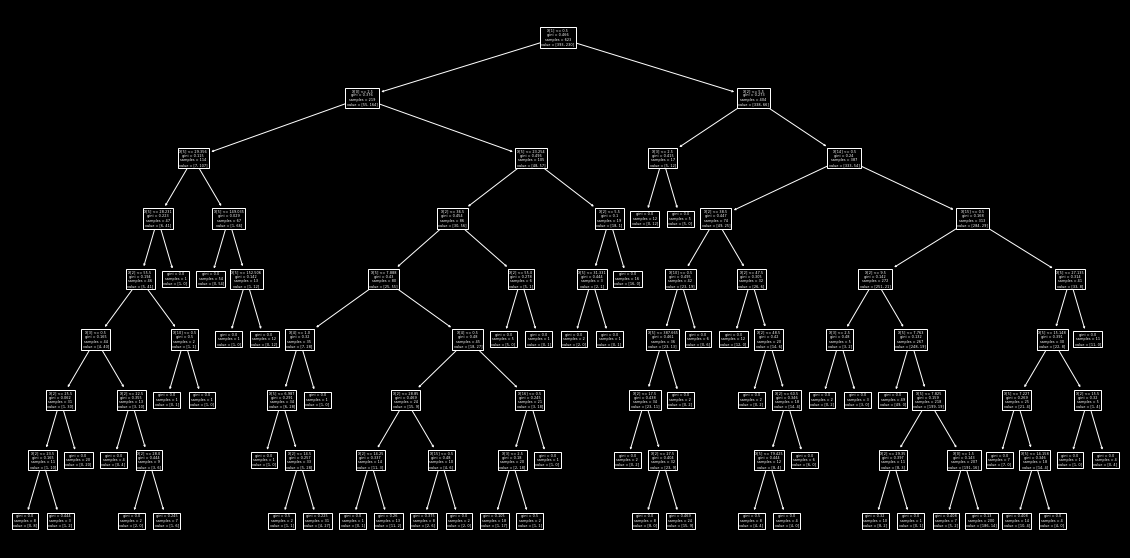

In [21]:
from sklearn.tree import plot_tree
from matplotlib.pyplot import figure

figure(figsize=(20, 10))
plot_tree(model)
plt.show()

# Crossvalidation

In [35]:
from sklearn.model_selection import GridSearchCV

param_space = {
    'min_samples_leaf': range(1, 10), 
    'max_depth': range(1, 10)
}
model = DecisionTreeClassifier()
gs = GridSearchCV(model, param_space)
gs.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 10)})

In [45]:
pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score').iloc[1, 4:]

param_max_depth                                                 5
param_min_samples_leaf                                          4
params                    {'max_depth': 5, 'min_samples_leaf': 4}
split0_test_score                                           0.824
split1_test_score                                            0.88
split2_test_score                                           0.792
split3_test_score                                        0.887097
split4_test_score                                        0.822581
mean_test_score                                          0.841135
std_test_score                                           0.036538
rank_test_score                                                 1
Name: 39, dtype: object

# DoDOmu

- dodać do X_val brakujące featurey
- zrobić predict i zapisać wyniki to pliku titanic/submission.csv
- wrzucić to na kaggla (sprawdzić jaka jest komenda kaggle submission .... titanic/submission.csv) + dodać ją do README.md

In [60]:
X_val['T'] = X_train['T'].mean()

In [62]:
gs.predict(X_val)

C:\Users\Mateusz\miniconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').